In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
warnings.filterwarnings('ignore')
#

In [ ]:
df_train = pd.read_csv('/content/drive/My Drive/house_prices/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/house_prices/test.csv')

In [ ]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
#Check for nulls
missing_values = df_train.isnull().sum()
# Filter and display only columns with missing values
missing_columns = missing_values[missing_values > 0]
missing_columns

,0
LotFrontage,259
Alley,1369
MasVnrType,872
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In [ ]:
df_train['MSSubClass']

,MSSubClass
0,60
1,20
2,60
3,70
4,60
...,...
1455,60
1456,20
1457,70
1458,20


In [ ]:
df_train.duplicated().sum()

0

In [ ]:
#Check for duplicates
idsUnique = len(set(df_train.Id))
idsTotal = df_train.shape[0]
idsDupli = idsTotal - idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Drop Id column
df_train.drop("Id", axis = 1, inplace = True)

There are 0 duplicate IDs for 1460 total entries


In [ ]:
#descriptive statistics summary
df_train['SalePrice'].describe()

,SalePrice
count,1460.000
mean,180921.196
std,79442.503
min,34900.000
25%,129975.000
50%,163000.000
75%,214000.000
max,755000.000


<Axes: xlabel='SalePrice', ylabel='Density'>

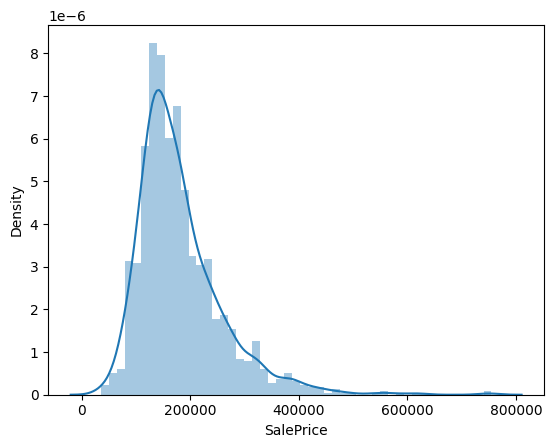

In [ ]:
sns.distplot(df_train['SalePrice'])

In [ ]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Looking for Outliers

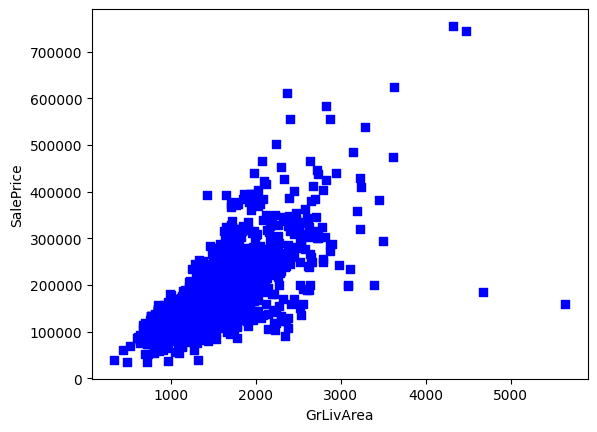

In [ ]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'], c="blue", marker='s')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()


In [ ]:
df_train['GrLivArea'].describe()

,GrLivArea
count,1460.000
mean,1515.464
std,525.480
min,334.000
25%,1129.500
50%,1464.000
75%,1776.750
max,5642.000


In [ ]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
df_train.loc[:, "BedroomAbvGr"] = df_train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("No")
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("No")
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("No")
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("No")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("No")
df_train.loc[:, "BsmtFullBath"] = df_train.loc[:, "BsmtFullBath"].fillna(0)
df_train.loc[:, "BsmtHalfBath"] = df_train.loc[:, "BsmtHalfBath"].fillna(0)
df_train.loc[:, "BsmtUnfSF"] = df_train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
df_train.loc[:, "CentralAir"] = df_train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
df_train.loc[:, "Condition1"] = df_train.loc[:, "Condition1"].fillna("Norm")
df_train.loc[:, "Condition2"] = df_train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
df_train.loc[:, "EnclosedPorch"] = df_train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
df_train.loc[:, "ExterCond"] = df_train.loc[:, "ExterCond"].fillna("TA")
df_train.loc[:, "ExterQual"] = df_train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("No")
df_train.loc[:, "Fireplaces"] = df_train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("No")
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("No")
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("No")
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("No")
df_train.loc[:, "GarageArea"] = df_train.loc[:, "GarageArea"].fillna(0)
df_train.loc[:, "GarageCars"] = df_train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
df_train.loc[:, "HalfBath"] = df_train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
df_train.loc[:, "HeatingQC"] = df_train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
df_train.loc[:, "KitchenAbvGr"] = df_train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
df_train.loc[:, "KitchenQual"] = df_train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
df_train.loc[:, "LotFrontage"] = df_train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
df_train.loc[:, "LotShape"] = df_train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")
df_train.loc[:, "MasVnrArea"] = df_train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("No")
df_train.loc[:, "MiscVal"] = df_train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
df_train.loc[:, "OpenPorchSF"] = df_train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
df_train.loc[:, "PavedDrive"] = df_train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("No")
df_train.loc[:, "PoolArea"] = df_train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
df_train.loc[:, "SaleCondition"] = df_train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
df_train.loc[:, "ScreenPorch"] = df_train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
df_train.loc[:, "TotRmsAbvGrd"] = df_train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
df_train.loc[:, "WoodDeckSF"] = df_train.loc[:, "WoodDeckSF"].fillna(0)

In [ ]:
# Some numerical features are actually really categories
# df_train = df_train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45",
#                                        50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",
#                                        80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120",
#                                        150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
#                        "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
#                                    7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
#                       })

In [ ]:
df_train['MSSubClass']

,MSSubClass
0,60
1,20
2,60
3,70
4,60
...,...
1455,60
1456,20
1457,70
1458,20


In [ ]:
# Encode some categorical features as ordered numbers when there is information in the order
df_train = df_train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )


Then we will create new features, in 3 ways :

- Simplifications of existing features
- Combinations of existing features
- Polynomials on the top 10 existing features

In [ ]:
# Create new features
# 1* Simplifications of existing features
df_train["SimplOverallQual"] = df_train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df_train["SimplOverallCond"] = df_train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
df_train["SimplPoolQC"] = df_train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
df_train["SimplGarageCond"] = df_train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
df_train["SimplGarageQual"] = df_train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
df_train["SimplFireplaceQu"] = df_train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_train["SimplFireplaceQu"] = df_train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_train["SimplFunctional"] = df_train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
df_train["SimplKitchenQual"] = df_train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
df_train["SimplHeatingQC"] = df_train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
df_train["SimplBsmtFinType1"] = df_train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
df_train["SimplBsmtFinType2"] = df_train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
df_train["SimplBsmtCond"] = df_train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
df_train["SimplBsmtQual"] = df_train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
df_train["SimplExterCond"] = df_train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
df_train["SimplExterQual"] = df_train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
df_train["OverallGrade"] = df_train["OverallQual"] * df_train["OverallCond"]
# Overall quality of the garage
df_train["GarageGrade"] = df_train["GarageQual"] * df_train["GarageCond"]
# Overall quality of the exterior
df_train["ExterGrade"] = df_train["ExterQual"] * df_train["ExterCond"]
# Overall kitchen score
df_train["KitchenScore"] = df_train["KitchenAbvGr"] * df_train["KitchenQual"]
# Overall fireplace score
df_train["FireplaceScore"] = df_train["Fireplaces"] * df_train["FireplaceQu"]
# Overall garage score
df_train["GarageScore"] = df_train["GarageArea"] * df_train["GarageQual"]
# Overall pool score
df_train["PoolScore"] = df_train["PoolArea"] * df_train["PoolQC"]
# Simplified overall quality of the house
df_train["SimplOverallGrade"] = df_train["SimplOverallQual"] * df_train["SimplOverallCond"]
# Simplified overall quality of the exterior
df_train["SimplExterGrade"] = df_train["SimplExterQual"] * df_train["SimplExterCond"]
# Simplified overall pool score
df_train["SimplPoolScore"] = df_train["PoolArea"] * df_train["SimplPoolQC"]
# Simplified overall garage score
df_train["SimplGarageScore"] = df_train["GarageArea"] * df_train["SimplGarageQual"]
df_train["SimplFireplaceScore"] = df_train["Fireplaces"] * df_train["SimplFireplaceQu"]
# Simplified overall kitchen score
df_train["SimplKitchenScore"] = df_train["KitchenAbvGr"] * df_train["SimplKitchenQual"]
# Total number of bathrooms
df_train["TotalBath"] = df_train["BsmtFullBath"] + (0.5 * df_train["BsmtHalfBath"]) + \
df_train["FullBath"] + (0.5 * df_train["HalfBath"])
# Total SF for house (incl. basement)
df_train["AllSF"] = df_train["GrLivArea"] + df_train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
df_train["AllFlrsSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"]
# Total SF for porch
df_train["AllPorchSF"] = df_train["OpenPorchSF"] + df_train["EnclosedPorch"] + \
df_train["3SsnPorch"] + df_train["ScreenPorch"]
# Has masonry veneer or not
df_train["HasMasVnr"] = df_train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1,
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
df_train["BoughtOffPlan"] = df_train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0,
                                                            "Family" : 0, "Normal" : 0, "Partial" : 1})

In [ ]:
df_train.dtypes

,0
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
Street,int64
...,...
AllSF,int64
AllFlrsSF,int64
AllPorchSF,int64
HasMasVnr,int64


In [ ]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,SimplPoolScore,SimplGarageScore,SimplFireplaceScore,SimplKitchenScore,TotalBath,AllSF,AllFlrsSF,AllPorchSF,HasMasVnr,BoughtOffPlan
0,60,RL,65.000,8450,2,None,4,Lvl,4,Inside,...,0,548,0,2,3.500,2566,1710,61,1,0
1,20,RL,80.000,9600,2,None,4,Lvl,4,FR2,...,0,460,1,1,2.500,2524,1262,0,0,0
2,60,RL,68.000,11250,2,None,3,Lvl,4,Inside,...,0,608,1,2,3.500,2706,1786,42,1,0
3,70,RL,60.000,9550,2,None,3,Lvl,4,Corner,...,0,642,2,2,2.000,2473,1717,307,0,0
4,60,RL,84.000,14260,2,None,3,Lvl,4,FR2,...,0,836,1,2,3.500,3343,2198,84,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.000,7917,2,None,4,Lvl,4,Inside,...,0,460,1,1,2.500,2600,1647,40,0,0
1456,20,RL,85.000,13175,2,None,4,Lvl,4,Inside,...,0,500,2,1,3.000,3615,2073,0,1,0
1457,70,RL,66.000,9042,2,None,4,Lvl,4,Inside,...,0,252,4,2,2.000,3492,2340,60,0,0
1458,20,RL,68.000,9717,2,None,4,Lvl,4,Inside,...,0,240,0,2,2.000,2156,1078,112,0,0


In [ ]:
# # Find most important features relative to target
# print("Find most important features relative to target")
# corr = df_train.corr()
# corr.sort_values(["SalePrice"], ascending = False, inplace = True)
# print(corr.SalePrice)

In [ ]:
# Create new features
# 3* Polynomials on the top 10 existing features
df_train["OverallQual-s2"] = df_train["OverallQual"] ** 2
df_train["OverallQual-s3"] = df_train["OverallQual"] ** 3
df_train["OverallQual-Sq"] = np.sqrt(df_train["OverallQual"])
df_train["AllSF-2"] = df_train["AllSF"] ** 2
df_train["AllSF-3"] = df_train["AllSF"] ** 3
df_train["AllSF-Sq"] = np.sqrt(df_train["AllSF"])
df_train["AllFlrsSF-2"] = df_train["AllFlrsSF"] ** 2
df_train["AllFlrsSF-3"] = df_train["AllFlrsSF"] ** 3
df_train["AllFlrsSF-Sq"] = np.sqrt(df_train["AllFlrsSF"])
df_train["GrLivArea-2"] = df_train["GrLivArea"] ** 2
df_train["GrLivArea-3"] = df_train["GrLivArea"] ** 3
df_train["GrLivArea-Sq"] = np.sqrt(df_train["GrLivArea"])
df_train["SimplOverallQual-s2"] = df_train["SimplOverallQual"] ** 2
df_train["SimplOverallQual-s3"] = df_train["SimplOverallQual"] ** 3
df_train["SimplOverallQual-Sq"] = np.sqrt(df_train["SimplOverallQual"])
df_train["ExterQual-2"] = df_train["ExterQual"] ** 2
df_train["ExterQual-3"] = df_train["ExterQual"] ** 3
df_train["ExterQual-Sq"] = np.sqrt(df_train["ExterQual"])
df_train["GarageCars-2"] = df_train["GarageCars"] ** 2
df_train["GarageCars-3"] = df_train["GarageCars"] ** 3
df_train["GarageCars-Sq"] = np.sqrt(df_train["GarageCars"])
df_train["TotalBath-2"] = df_train["TotalBath"] ** 2
df_train["TotalBath-3"] = df_train["TotalBath"] ** 3
df_train["TotalBath-Sq"] = np.sqrt(df_train["TotalBath"])
df_train["KitchenQual-2"] = df_train["KitchenQual"] ** 2
df_train["KitchenQual-3"] = df_train["KitchenQual"] ** 3
df_train["KitchenQual-Sq"] = np.sqrt(df_train["KitchenQual"])
df_train["GarageScore-2"] = df_train["GarageScore"] ** 2
df_train["GarageScore-3"] = df_train["GarageScore"] ** 3
df_train["GarageScore-Sq"] = np.sqrt(df_train["GarageScore"])

In [ ]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = df_train.select_dtypes(include = ["object"]).columns
numerical_features = df_train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("SalePrice")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = df_train[numerical_features]
train_cat = df_train[categorical_features]

Numerical features : 119
Categorical features : 24


In [ ]:
# Handle remaining missing values for numerical features by using median as replacement
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [ ]:
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.75]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

75 skewed numerical features to log transform


In [ ]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


Modeling

In [ ]:
train = pd.concat([train_num, train_cat], axis = 1)
print("Num  numbner of features :" + str(train.shape[1]))

#Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(
                                    train,
                                    df_train.SalePrice,
                                    test_size=0.3,
                                    random_state=0)
print("Training features shape: " + str(X_train.shape))
print("Training target shape: " + str(y_train.shape))
print("Test features shape: " + str(X_test.shape))
print("Test target shape: " + str(y_test.shape))

Num  numbner of features :295
Training features shape: (1022, 295)
Training target shape: (1022,)
Test features shape: (438, 295)
Test target shape: (438,)


In [ ]:
#Standardizing the numerical features
stdSc = StandardScaler()
X_train = stdSc.fit_transform(X_train.loc[:, numerical_features])
X_test = stdSc.transform(X_test.loc[:,numerical_features])

In [ ]:
#Define error measure : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_train(model):
  rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=10))
  return (rmse)

def rmse_test(model):
  rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring=scorer, cv=10))
  return (rmse)

RMSE on Training set : 1.1180703884173062e+16
RMSE on Test set : 3.508104968390367e+16


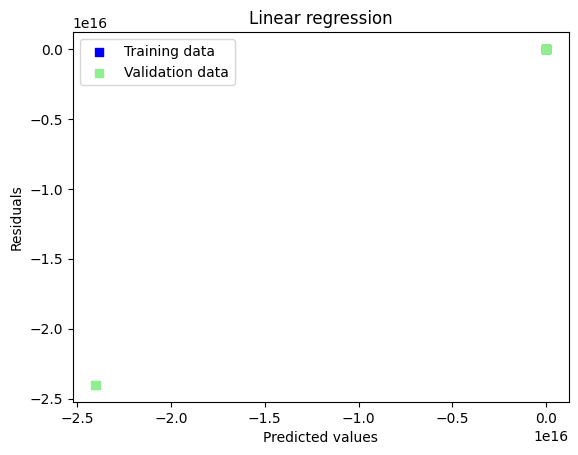

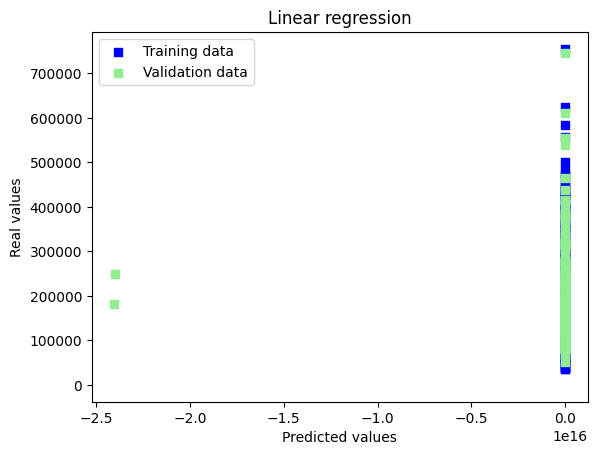

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_train(lr).mean())
print("RMSE on Test set :", rmse_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Regularization is a very useful method to handle collinearity, filter out noise from data, and eventually prevent overfitting. The concept behind regularization is to introduce additional information (bias) to penalize extreme parameter weights.

Best alpha : 6.0
Try again for more precision with alphas centered around 6.0
Best alpha : 7.5
Ridge RMSE on Training set : 28630.992223405592
Ridge RMSE on Test set : 49300.77893427528


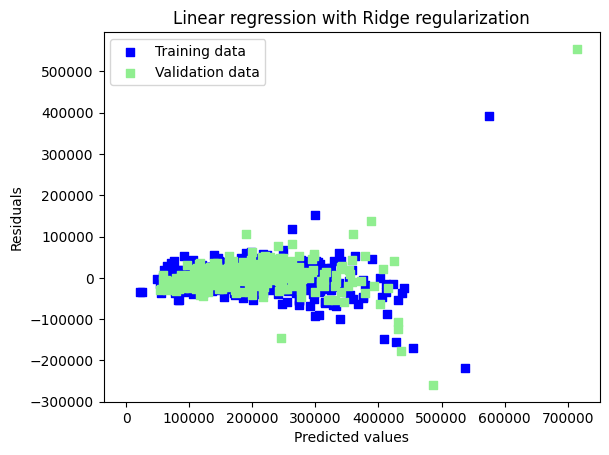

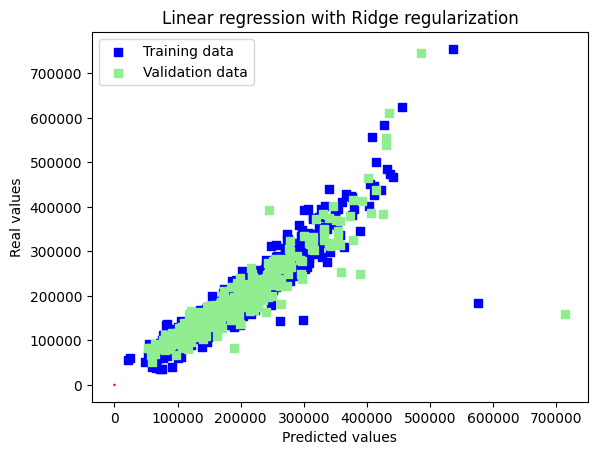

NameError: name 'feature_names' is not defined

In [ ]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85,
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

X_train = pd.DataFrame(X_train, columns=feature_names)

# Now coefs will work with the DataFrame columns
coefs = pd.Series(ridge.coef_, index=X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

LASSO stands for Least Absolute Shrinkage and Selection Operator. It is an alternative regularization method, where we simply replace the square of the weights by the sum of the absolute value of the weights. In contrast to L2 regularization, L1 regularization yields sparse feature vectors : most feature weights will be zero. Sparsity can be useful in practice if we have a high dimensional dataset with many features that are irrelevant.

Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 6.500000000000001e-05
Lasso RMSE on Training set : 29454.74784098135
Lasso RMSE on Test set : 39744.430001750276


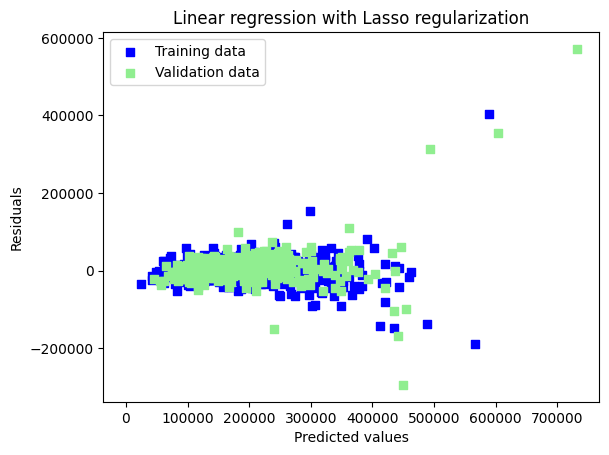

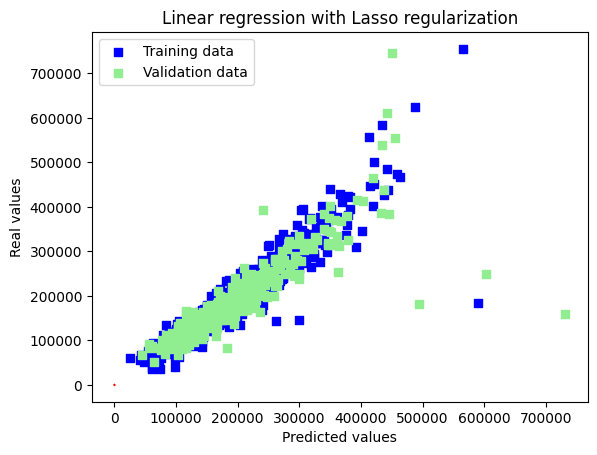

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                          0.3, 0.6, 1],
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8,
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05,
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35,
                          alpha * 1.4],
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on Training set :", rmse_train(lasso).mean())
print("Lasso RMSE on Test set :", rmse_test(lasso).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()